Wir benötigen die folgende Pakete:
- `pandas` -> Tabellenkalkulation in Python. In `pandas` wird eine Tabelle als `DataFrame` bezeichnet.
- `geopandas` -> Erweiterung von `pandas`.
- `shapely` -> beinhaltet Datentypen für Geometrien (Punkte und Polygone)
- `folium` -> ist eine Bibliothek in Python zur Visualisierung von Geodaten und interaktiven Karten. Es baut auf der JavaScript-Bibliothek Leaflet auf und ermöglicht es, Kartenobjekte zu erstellen, verschiedene Ebenen hinzuzufügen und sie mit Daten zu verbinden.
- `matplotlib` -> ist eine umfangreiche Sammlung von Funktionen und Methoden zur Erstellung von statistischen Grafiken, Plots und Diagrammen. Sie ermöglicht es, Daten visuell darzustellen und komplexe visuelle Analysen durchzuführen.
- `re` -> Regular Expression

In [1]:
import pandas as pd
import geopandas as gpd
import re
import folium
from shapely.geometry import Point
from shapely import wkt
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

### Einlesen der Datentabellen

1. Einlesen als `pandas`-Data Frame mit der `pandas`-Funktion [`read_csv()`]. Die Option encoding = "utf-8" gibt an, dass die Datei im UTF-8-Format codiert ist.
2. Die Spaltennamen ["Straßenname", "Personname", "Gender", "Koordinaten", "PLZ"] werden festgelegt und die Reihenfolge der Spaltennamen entspricht der Reihenfolge der Spalten in der TSV-Datei.

In [3]:
data = pd.read_csv("../Datenkompetenz_Räumliche_Analyse/Daten/query1_bereinigt.tsv", sep = "\t" , encoding = "utf-8")
data.columns = ["Straßenname", "Personname", "Gender","Koordinaten", "PLZ"]

Es wird überprüft, ob es in der Spalte "Straßenname" des DataFrames "data" duplizierte Werte gibt.
- [data.duplicated(subset=['Straßenname'])] angibt, welche Zeilen in der Spalte "Straßenname" duplizierte Werte haben und gibt  nur die Zeilen zurück, die mit duplizierten Werten im "Straßenname"-Feld extrahiert.
- Die extrahierten Zeilen, die die Duplikate enthalten, werden der Variablen "duplicates" zugewiesen.

In [4]:
# Überprüfen, ob duplizierte Straßennamen vorhanden sind
duplicates = data[data.duplicated(subset=['Straßenname'])]
if duplicates.empty:
    print("Es gibt keine duplizierte Straßenname.")
else:
    print(duplicates)

                       Straßenname                        Personname  \
35                Senefelderstraße                  Alois Senefelder   
84                   Wüllnerstraße                     Franz Wüllner   
116          Berthold-Haupt-Straße                    Berthold Haupt   
156                  Corinthstraße                     Lovis Corinth   
163                 Augustusbrücke                 August der Starke   
166            Emerich-Ambros-Ufer                    Emerich Ambros   
172                   Carolabrücke  Carola von Wasa-Holstein-Gottorp   
182                   Wallotstraße                       Paul Wallot   
197                    Dürerstraße                    Albrecht Dürer   
198                    Dürerstraße                    Albrecht Dürer   
242                  Behringstraße                  Emil von Behring   
315             Maxim-Gorki-Straße                       Maxim Gorki   
418            Käthe-Kollwitz-Ufer                    Käthe Koll

Nach Überprüfung des duplizierten Straßennamens wurde festgestellt, dass es insgesamt drei Situationen gibt:
1. Dieselbe Straße wurde nach mehrere Personen benannt, einer von denen sind die vorherige genannte Name (alte Daten).
2. Dieselbe Straße hat mehrere Postleitzahlen.
3. Straßen mit demselben Namen in verschiedenen Stadtteilen.

- Für 1. Situation muss man durch genauere Überprüfungen manuell alte Daten entfernen. 【schon manuell bereinigt】
- Für 2. Situation muss nur ein Data beibehalten werden, wenn man die Postleitzahlen zur Statistik nicht brauchst.
- Für 3. Situation muss man nichts tun.

Um die Anzahl aller Straßen zu zählen (ohne die Anzahl der Duplikaten), muss man eine automatische Deduplizierung bei der 2. Situation durchgeführt werden, d.h. für Daten mit mehreren Postleitzahlen in derselben Straße werden nur die ersten Daten gespeichert.
1. Zuerst werden die Zeile mit Duplikat "Straßenname", "Personname" und "Koordinaten" extrahiert, in dem der Parameter keep=False bedeutet, dass alle doppelten Zeilen in das Ergebnis einbezogen werden. Die extrahierte Zeile werden der Variablen double_streets_all zugewiesen. 
2. Danach werden werden die Zeilen mit Duplikat "Straßenname", "Personname" und "Koordinaten" extrahiert, in dem der Parameter keep='first' bedeutet, nur das erste Vorkommen doppelter Zeilen beizubehalten.  Die extrahierte Zeile werden der Variablen double_streets_first zugewiesen. 
3. total_street = data['Straßenname'].count() zählt die Gesamtanzahl der Straßennamen im DataFrame "data" und speichert sie in der Variablen "total_street".
4. Zu der Variable "final_street_number" werden die Anzahl der eindeutigen Straßen im DataFrame "data" unter Berücksichtigung von Duplikaten basierend auf Straßenname und Koordinaten zugewiesen. Die endgültige Anzahl der Straßen erhält man, indem man die Anzahl der duplizierten Straßen (Länge von „duplicate_streets_all“) von der Gesamtzahl der Straßen subtrahiert und dann die Anzahl der Straßen addiert, die für das erste Duplikat beibehalten wurden (Länge von „duplicate_streets_first“).

In [5]:
# Anzahl aller Straßen
duplicate_streets_all = data[data.duplicated(subset=['Straßenname', 'Personname', 'Koordinaten'], keep= False)]
duplicate_streets_first = data[data.duplicated(subset=['Straßenname', 'Personname', 'Koordinaten'], keep='first')]
total_street = data['Straßenname'].count()
final_street_number = total_street - len(duplicate_streets_all) + len(duplicate_streets_first)
#final_street_number

1. Verwenden den Indexoperator ~data.index.isin(duplicate_streets_all.index), um Zeilen auszuwählen, die nicht in der Indexsammlung „duplicate_streets_all“ enthalten sind, und weisen Sie das Ergebnis der Variablen „new_data“ zu. Dadurch entsteht ein new_data ohne duplizierte Zeilen.
2. Verwenden die Funktion pd.concat(), um new_data und double_streets_first zu verbinden, nämlich die deduplizierten Straßendaten zusammenzuführen. Der Parameter „ignore_index=True“ bedeutet, aufeinanderfolgende ganzzahlige Indizes neu zu generieren. Die bereinigten Daten werden schließlich in der Variablen new_data gespeichert.

In [6]:
# Deduplikation
new_data = data[~data.index.isin(duplicate_streets_all.index)]
new_data = pd.concat([new_data, duplicate_streets_first], ignore_index=True)
new_data

,Straßenname,Personname,Gender,Koordinaten,PLZ
0,Arndtstraße,Ernst Moritz Arndt,männlich,Point(13.773429 51.068022),1099
1,Louis-Braille-Straße,Louis Braille,männlich,Point(13.773708 51.068286),1099
2,Marienallee,Maria Anna von Portugal,weiblich,Point(13.766196 51.073957),1099
3,Arno-Holz-Allee,Arno Holz,männlich,Point(13.766793 51.071709),1099
4,Nieritzstraße,Karl Gustav Nieritz,männlich,Point(13.741466 51.062148),1097
...,...,...,...,...,...
896,Marienbrücke,Maria Anna von Bayern,weiblich,Point(13.7319 51.0608),1097
897,Ammonstraße,Christoph Ammon,männlich,Point(13.7224 51.0461),1069
898,Rosa-Luxemburg-Platz,Rosa Luxemburg,weiblich,Point(13.75291667 51.05868056),1099
899,Hans-Thoma-Straße,Hans Thoma,männlich,Point(13.76125 51.02189),1217


Nun arbeiten wir mit einem Datensatz, der die Berufe aller Personen enthält.
1. Einlesen als pandas-Data Frame mit der pandas-Funktion [read_csv()]. Die Option encoding = "utf-8" gibt an, dass die Datei im UTF-8-Format codiert ist.
2. Die Spaltennamen ["Straßenname", "Personname", "Gender", "Beruf", "Koordinaten", "PLZ"] werden festgelegt und die Reihenfolge der Spaltennamen entspricht der Reihenfolge der Spalten in der TSV-Datei.

In [7]:
data2 = pd.read_csv("../Datenkompetenz_Räumliche_Analyse/Daten/query2_bereinigt.tsv", sep = "\t" , encoding = "utf-8")
data2.columns = ["Straßenname", "Personname", "Gender", "Beruf", "Koordinaten", "PLZ"]

Verwenden die gleiche Methode zur Deduplikation wie zuvor und speichern die bereinigten Daten in new_data2.

In [8]:
# Deduplikation
duplicate_rows = data2[data2.duplicated(subset=['Straßenname', 'Personname', 'Beruf', 'Koordinaten'], keep=False)]
new_data2 = data2.drop_duplicates(subset=['Straßenname', 'Personname', 'Beruf', 'Koordinaten'])
new_data2

,Straßenname,Personname,Gender,Beruf,Koordinaten,PLZ
0,Galileistraße,Galileo Galilei,männlich,Wissenschaftler,Point(13.709214 51.097461),1129
1,Galileistraße,Galileo Galilei,männlich,Astronom,Point(13.709214 51.097461),1129
2,Galileistraße,Galileo Galilei,männlich,Ingenieur,Point(13.709214 51.097461),1129
3,Galileistraße,Galileo Galilei,männlich,Astrologe,Point(13.709214 51.097461),1129
4,Galileistraße,Galileo Galilei,männlich,Physiker,Point(13.709214 51.097461),1129
...,...,...,...,...,...,...
3403,Helena-Rott-Straße,Helena Rott,weiblich,Sänger,Point(13.79491 50.991591),1239
3404,Helena-Rott-Straße,Helena Rott,weiblich,Musiker,Point(13.79491 50.991591),1239
3405,Jakob-Weinheimer-Straße,Jakob Weinheimer,männlich,Maler,Point(13.83574 51.12318),1465
3406,Albert-Venus-Weg,Franz Albert Venus,männlich,Maler,Point(13.82804 51.04984),1326


### Visualisierung - Diagramme


Ein Kreisdiagramm wird erstellt, das die Verteilung der Geschlechter in den Straßennamen repräsentiert, einschließlich prozentualer Anteile und absoluter Zahlen. Der DataFrame wird nach der Spalte "Geschlecht" gruppiert, und das Erscheinungsbild des Kreisdiagramms wird angegeben.

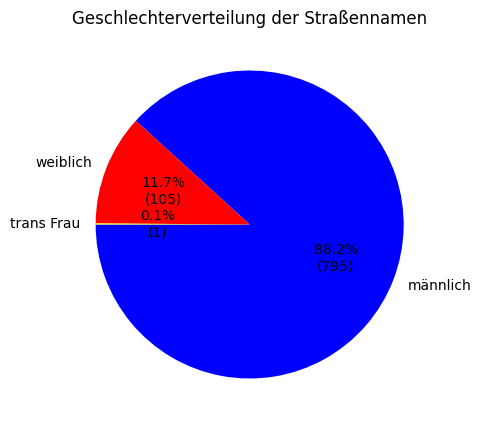

In [9]:
# Genderverteilung 
gender_counts = new_data['Gender'].value_counts()

#Kreisdiagramm
colors = ['blue', 'red', 'yellow']
plt.figure(figsize=(7,5))
plt.pie(gender_counts, labels=gender_counts.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*gender_counts.sum())})", startangle=900, colors=colors)
#print(gender_counts.index)
plt.title('Geschlechterverteilung der Straßennamen')
plt.show()

Zur Visualisierung der Berufeverteilung:
1. Der wird DataFrame nach der Spalte "Gender" sortiert, um die männlichen Berufe zu erfassen. 
2. Die ersten zehn Berufe werden als "männlich_counts" gespeichert.

Zur Visualisierung der Berufeverteilung:
1. Der DataFrame nach den Spalten "Gender" (weiblich und trans Frau) sortiert, um die entsprechenden Berufe zu erfassen. 
2. Die ersten zehn Berufe werden als "weiblich_counts" gespeichert.
3. Es werden zwei Kreisdiagramme erstellt, um die Berufeverteilung zu visualisieren.

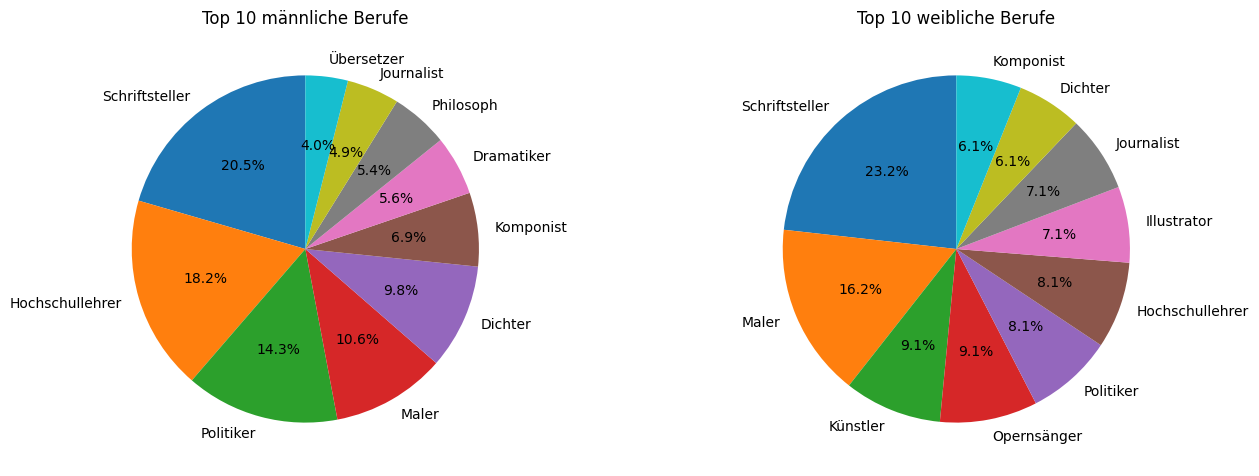

In [10]:
# Visualisierung der Berufeverteilung
#DataFrame wird in der Spalte "Gender" nach "männlich" sortiert und die erste 10 Berufe werden als männlich_counts gespeichert
männlich_data = new_data2[new_data2['Gender'] == 'männlich']
männlich_counts = männlich_data['Beruf'].value_counts().head(10)

#DataFrame wird in der Spalte "Gender" nach "weiblich" und "trans Frau" sortiert und die erste 10 Berufe werden als weiblich_counts gespeichert
weiblich_data = new_data2[new_data2['Gender'].isin(['trans Frau', 'weiblich'])]
weiblich_counts = weiblich_data['Beruf'].value_counts().head(10)

#Die zwei Kreisdiagramme werden gebildet
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 15))
ax1.pie(männlich_counts, labels=männlich_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Top 10 männliche Berufe')
ax2.pie(weiblich_counts, labels=weiblich_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 10 weibliche Berufe')
plt.subplots_adjust(wspace=0.5)
plt.show()

Balkendiagramm zeigt die Anzahl der weiblichen Berufe

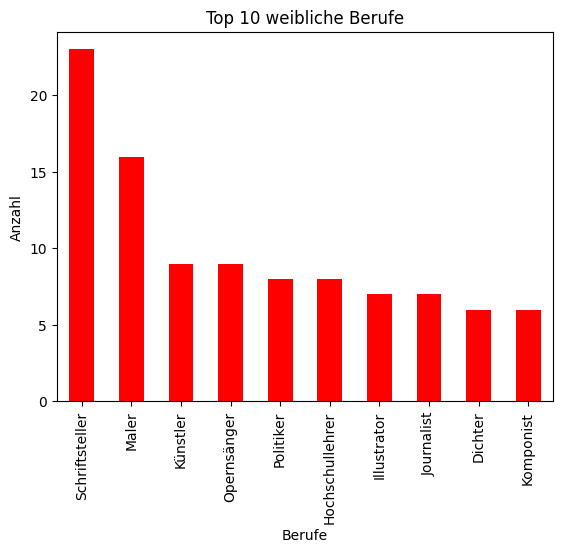

In [11]:
weiblich_counts.plot(kind="bar", color="red")

plt.title('Top 10 weibliche Berufe')
plt.xlabel('Berufe')
plt.ylabel('Anzahl')

plt.show()

### Visualisierung - Karte


In unserem Projekt beabsichtigen wir, die Verteilung der weiblichen Straßen in verschiedenen Stadtbezirken zu untersuchen und auf einer Karte darzustellen. Unser Ziel ist es, die Bezirke entsprechend der Anzahl der weiblichen Straßen von den Bezirken mit den wenigsten bis zu den Bezirken mit den meisten weiblichen Straßen zu ordnen.

Um die alle weibliche und männliche Straßen auf der Karte darzustellen, sollen die Koordinaten in der `new_data` - Datei bereinigt und formatiert werden, in dem sie in das korrekte Format "POINT (Koordinate)" gebracht werden. Anschließend werden die bereinigten Koordinaten in ein GeoDataFrame umgewandelt, das für die Geodatenverarbeitung verwendet werden kann.

In [12]:
# Funktion zum Bereinigen und Formatieren der Koordinaten
def clean_coordinate(coord):
    match = re.search(r'\((.*?)\)', coord)
    if match:
        coord = match.group(1)
    return 'POINT ({})'.format(coord)

# Bereinigung und Konvertierung der Koordinaten in die "geometry"-Spalte
new_data['Koordinaten'] = new_data['Koordinaten'].astype(str)
new_data['Koordinaten'] = new_data['Koordinaten'].apply(lambda coord: clean_coordinate(coord))
new_data['Koordinaten'] = new_data['Koordinaten'].apply(wkt.loads)

# Erstellen des GeoDataFrames
gdf = gpd.GeoDataFrame(new_data, geometry='Koordinaten', crs=4326)

Mit diesen beiden Zeilen des Codes werden zwei separate DataFrames erstellt: `name_w`, das alle Zeilen enthält, bei denen das Geschlecht nicht "männlich" ist (weiblich und trans Frau), und `name_m`, das alle Zeilen enthält, bei denen das Geschlecht "männlich" ist.

In [13]:
name_w = new_data[~new_data["Gender"].str.contains("männlich", na=False)]
name_m = new_data[new_data["Gender"].str.contains("männlich", na=False)]

Zur Darstellung von Bezirken auf einer Karte wurde eine [`Datei`](https://opendata.dresden.de/informationsportal/#app/mainpage//Postleitzahlgebiete) mit der Information zu den Bezirken von Dresden, einschließlich ihrer Postleitzahlen, Lagen, Beschreibungen und geometrischen Darstellungen. Darübe hinaus enthält die Datei eine Spalte "geom" die geometrische Darstellung jedes Bezirks im [`(WKT)-Format`](http://giswiki.org/wiki/Well_Known_Text)(Polygon).

In [14]:
stadtbezirk = pd.read_csv("../Datenkompetenz_Räumliche_Analyse/Daten/Postleitzahlgebiete.csv", sep = ";", encoding='utf-8')

Der folgende Code teilt die Werte in der Spalte "geom" des DataFrames `stadtbezirk` auf und erstellt daraus ein GeoDataFrame. Die Spalte "geom" enthält ursprünglich geometrische Daten im Well-Known Text [`(WKT)-Format`](http://giswiki.org/wiki/Well_Known_Text). Der Code teilt diese Werte anhand des Trennzeichens ";" in zwei Teile auf und speichert sie in den neuen Spalten "SRID" und "geometry". Anschließend wird die Spalte "geometry" in Geometrieobjekte umgewandelt, indem die Funktion `wkt.loads` auf jeden Wert angewendet wird. Schließlich wird ein GeoDataFrame namens "gdf" erstellt, indem der ursprüngliche DataFrame "stadtbezirk" verwendet wird und die Spalte "geometry" als Geometriespalte festgelegt wird. Das resultierende GeoDataFrame enthält die aufgeteilten Werte aus der Spalte "geom" sowie die Geometrieobjekte in der Spalte "geometry".

In [15]:
#die Werte in der Spalte geom trennen
stadtbezirk[["SRID", "geometry"]] = stadtbezirk["geom"].str.split(';', n=1, expand=True)

# Spalte "geometry" in Geometrieobjekte konvertieren
stadtbezirk['geometry'] = stadtbezirk['geometry'].apply(wkt.loads)

# GeoDataFrame erstellen
gdf = gpd.GeoDataFrame(stadtbezirk, geometry='geometry')

Um die Daten zu Frauennamen-Straßen und Männernamen-Straßen zusammenzuführen, geografische Informationen hinzuzufügen und verschiedene Berechnungen durchzuführen, soll folgendes tun:

1. Die DataFrames "name_w" (Frauennamen-Straßendaten) und "stadtbezirk" (Gebietsdaten) werden basierend auf der Spalte "PLZ" und "plz" zusammengeführt, um das DataFrame "merged_data_w" zu erstellen. Es werden alle Zeilen aus beiden DataFrames beibehalten, auch wenn sie nicht übereinstimmen.

2. Das DataFrame "merged_data_w" wird nach Stadtgebiet ("SRID") und Postleitzahl ("plz") gruppiert, um die Anzahl der Frauennamen-Straßen pro Gebiet zu berechnen. Das Ergebnis wird im DataFrame "grouped_data_w" gespeichert.

3. Die Spalte "Straßenname" im DataFrame "grouped_data_w" wird in "AnzahlFrauenstraßen" umbenannt, um sie genauer zu beschreiben.

4. Die DataFrames "name_m" (Männernamen-Straßendaten) und "stadtbezirk" werden basierend auf der Spalte "PLZ" und "plz" zusammengeführt, um das DataFrame "merged_data_m" zu erstellen. Es werden nur die Zeilen aufgenommen, die in beiden DataFrames übereinstimmen.

5. Das DataFrame "merged_data_m" wird nach Stadtgebiet ("SRID") und Postleitzahl ("plz") gruppiert, um die Anzahl der Männernamen-Straßen pro Gebiet zu berechnen. Das Ergebnis wird im DataFrame "grouped_data_m" gespeichert.

6. Die Spalte "Straßenname" im DataFrame "grouped_data_m" wird in "AnzahlMännerstraßen" umbenannt, um sie genauer zu beschreiben.

7. Die DataFrames "grouped_data_w" und "grouped_data_m" werden basierend auf den Spalten "SRID" und "plz" zusammengeführt, um das DataFrame "merged_data" zu erstellen. Es werden nur die Zeilen aufgenommen, die in beiden DataFrames übereinstimmen.

8. Das DataFrame "merged_data" wird mit der Spalte "geometry" aus dem DataFrame "stadtbezirk" anhand der Spalte "plz" zusammengeführt, um geografische Informationen für jedes Gebiet hinzuzufügen. Es werden alle Zeilen aus "merged_data" beibehalten, auch wenn keine Übereinstimmung in der Spalte "plz" gefunden wird.

9. Es wird eine neue Spalte "GesamtAnzahlStraßen" erstellt, die die Gesamtanzahl der Straßen pro Gebiet berechnet, indem die Anzahl der Frauennamen-Straßen und die Anzahl der Männernamen-Straßen addiert werden.

10. Es wird eine neue Spalte "FemaleStreetsRatio" erstellt, die den Anteil der Frauennamen-Straßen am Gesamtvorkommen von Straßen pro Gebiet berechnet, indem die Anzahl der Frauennamen-Straßen durch die Gesamtanzahl der Straßen geteilt wird.

In [16]:
# Zusammenführen von Frauennamen-Straßendaten und Gebietsdaten anhand der Postleitzahl und des Stadtgebiets
merged_data_w = pd.merge(name_w, stadtbezirk, left_on='PLZ', right_on='plz', how='outer')

# Gruppieren nach Stadtgebiet und Postleitzahl, und Berechnen der Anzahl der Frauennamen-Straßen pro Gebiet
grouped_data_w = merged_data_w.groupby(['SRID', 'plz']).agg({'Straßenname': 'count'}).reset_index()
grouped_data_w = grouped_data_w.rename(columns={'Straßenname': 'AnzahlFrauenstraßen'})

# Zusammenführen von Männernamen-Straßendaten und Gebietsdaten anhand der Postleitzahl und des Stadtgebiets
merged_data_m = pd.merge(name_m, stadtbezirk, left_on='PLZ', right_on='plz', how='inner')

# Gruppieren nach Stadtgebiet und Postleitzahl, und Berechnen der Anzahl der Männernamen-Straßen pro Gebiet
grouped_data_m = merged_data_m.groupby(['SRID', 'plz']).agg({'Straßenname': 'count'}).reset_index()
grouped_data_m = grouped_data_m.rename(columns={'Straßenname': 'AnzahlMännerstraßen'})

# Zusammenführen der Anzahl der Frauennamen-Straßen und Männernamen-Straßen pro Gebiet
merged_data = pd.merge(grouped_data_w, grouped_data_m, on=['SRID', 'plz'], how='inner')

# Hinzufügen von geografischen Informationen pro Gebiet
merged_data = pd.merge(merged_data, stadtbezirk[['plz', 'geometry']], left_on='plz', right_on='plz', how='left')

# Berechnen der Gesamtanzahl der Straßen pro Gebiet (Anzahl der Frauennamen-Straßen + Anzahl der Männernamen-Straßen)
merged_data['GesamtAnzahlStraßen'] = merged_data['AnzahlFrauenstraßen'] + merged_data['AnzahlMännerstraßen']

# Berechnen des Anteils der Frauennamen-Straßen
merged_data['FemaleStreetsRatio'] = merged_data['AnzahlFrauenstraßen'] / merged_data['GesamtAnzahlStraßen']

#print(merged_data)

Um die Bezirke und die Anzahl der weiblichen Straßen auf einer Karte zu visualisieren, sollen die Bezirke entsprechend der Anzahl der weiblichen Straßen eingefärbt werden, wobei Bezirke mit weiblichen Straßen von Weiß bis leuchtenden Rot haben. Diese Darstellung ermöglicht es uns, die Verteilung der weiblichen Straßen auf einen Blick zu erfassen und Bezirke mit geringer und hoher Präsenz von weiblichen Straßen zu identifizieren.

In [17]:
# Nach dem Wert von FemaleStreetsRatio die Farbe festlegen
merged_data.loc[merged_data['FemaleStreetsRatio'] == 0, 'color'] = '#ffffff'  # Weiß
merged_data.loc[(merged_data['FemaleStreetsRatio'] > 0) & (merged_data['FemaleStreetsRatio'] < 0.05), 'color'] = '#ffeded'  # Hellrot oder Rosa
merged_data.loc[(merged_data['FemaleStreetsRatio'] >= 0.05) & (merged_data['FemaleStreetsRatio'] < 0.1), 'color'] = '#ffccbf'   # Pastellrot
merged_data.loc[(merged_data['FemaleStreetsRatio'] >= 0.1) & (merged_data['FemaleStreetsRatio'] < 0.15), 'color'] = '#ffad99'  # dunkleren Pastellrot
merged_data.loc[(merged_data['FemaleStreetsRatio'] >= 0.15) & (merged_data['FemaleStreetsRatio'] < 0.2), 'color'] = '#ff8c73'  # tiefen, warmen Rosa
merged_data.loc[(merged_data['FemaleStreetsRatio'] >= 0.2) & (merged_data['FemaleStreetsRatio'] < 0.25), 'color'] = '#ff6c4d'  # lebendigen Rot
merged_data.loc[(merged_data['FemaleStreetsRatio'] >= 0.25) & (merged_data['FemaleStreetsRatio'] < 0.3), 'color'] = '#ff4d27'  # intensiven Rostrot
merged_data.loc[merged_data['FemaleStreetsRatio'] >= 0.3, 'color'] = '#ff0000' # leuchtenden Rot

Danach werden die Bezirke gefiltert, die einen Anteil von mehr als 20% an Frauennamen-Straßen aufweisen, und wird dann eine Fusion mit den entsprechenden Frauennamen-Straßendaten durchgeführt.

In [18]:
"""# Filtern der Bezirke, die einen Anteil von mehr als 20% haben
filtered_data = merged_data[merged_data['FemaleStreetsRatio'] > 0.2]
district_plz = filtered_data['plz']

# Zusammenführen der Daten basierend auf gleicher PLZ
merged_name_w = pd.merge(name_w, district_plz, left_on='PLZ', right_on='plz', how='inner')

# Ausgabe der fusionierten Tabelle
print(merged_name_w)"""

"# Filtern der Bezirke, die einen Anteil von mehr als 20% haben\nfiltered_data = merged_data[merged_data['FemaleStreetsRatio'] > 0.2]\ndistrict_plz = filtered_data['plz']\n\n# Zusammenführen der Daten basierend auf gleicher PLZ\nmerged_name_w = pd.merge(name_w, district_plz, left_on='PLZ', right_on='plz', how='inner')\n\n# Ausgabe der fusionierten Tabelle\nprint(merged_name_w)"

Schließlich wird eine interaktive Karte mit verschiedenen Ebenen, um die Informationen über weibliche Bezirke, Straßen mit Frauennamen und Straßen mit Männernamen darzustellen. Es wird eine Legende erstellt, die die Farben und die entsprechenden Prozentsätze der weiblichen Straßenanteile zeigt.

In [19]:
# Erstelle die Grundkarte
m = folium.Map(location=[51.050409, 13.737262], zoom_start=11)  # Koordinaten für Dresden

# Füge die Ebene "weibliche Bezirke" hinzu
weibliche_bezirke_layer = folium.FeatureGroup(name='weibliche Bezirke')
for _, row in merged_data.iterrows():
    color = row['color']
    style = {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, style=style: style,
        tooltip=f"PLZ: {row['plz']}<br>Weibliche Straßenanteil: {row['FemaleStreetsRatio']*100:.2f}%"
    ).add_to(weibliche_bezirke_layer)
m.add_child(weibliche_bezirke_layer)

# Füge die Ebene "name_w" hinzu
name_w_layer = folium.FeatureGroup(name='Name_w-Straßen')
for _, row in name_w.iterrows():
    folium.CircleMarker(
        location=[row['Koordinaten'].y, row['Koordinaten'].x],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        tooltip=f"Straßenname: {row['Straßenname']}<br>Personenname: {row['Personname']}"
    ).add_to(name_w_layer)
m.add_child(name_w_layer)

# Füge die Ebene "name_m" hinzu
name_m_layer = folium.FeatureGroup(name='Name_m-Straßen')
for _, row in name_m.iterrows():
    folium.CircleMarker(
        location=[row['Koordinaten'].y, row['Koordinaten'].x],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        tooltip=f"Straßenname: {row['Straßenname']}<br>Personenname: {row['Personname']}"
    ).add_to(name_m_layer)
m.add_child(name_m_layer)

# Füge die Ebene-Control-Option hinzu
folium.LayerControl().add_to(m)

# Erstelle die Legende
legend_html = """
<div style="
    position: fixed;
    bottom: 50px; left: 50px; width: 130px; height: 240px;
    border: 2px solid grey; z-index: 9999; font-size: 14px;
    background-color: white; opacity: 0.8;
    ">
    <p style="margin: 5px 10px; font-weight: bold;">Legende</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ffffff; width: 20px; height: 10px; display: inline-block;"></span> 0%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ffeded; width: 20px; height: 10px; display: inline-block;"></span> 0-5%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ffccbf;width: 20px; height: 10px; display: inline-block;"></span> 5-10%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ffad99; width: 20px; height: 10px; display: inline-block;"></span> 10-15%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ff8c73; width: 20px; height: 10px; display: inline-block;"></span> 15-20%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ff6c4d; width: 20px; height: 10px; display: inline-block;"></span> 20-25%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ff4d27; width: 20px; height: 10px; display: inline-block;"></span> 25-30%</p>
    <p style="margin: 5px 10px;"><span style="background-color: #ff0000; width: 20px; height: 10px; display: inline-block;"></span> >30%</p>
</div>
"""

# Füge die Legende zur Karte hinzu
m.get_root().html.add_child(folium.Element(legend_html))

# Zeige die Karte an
m
